### Running MACRO

In this tutorial, we start from a single zone electricity system with four resource clusters: utility scale solar PV, land-based wind power generation, natural gas combined cycle power plants, and electricity storage. 

We consider three commodities: electricity, natural gas, and $\text{CO}_2$. 

Initially, hydrogen is modeled exogenously, adding a constant electricity demand for hydrogen production to the electricity demand time series. In other words, we assume the existance of an electrolyzer that continuously consumes electricity to meet the hydrogen demand.

We model a greenfield scenario with a carbon price of 200$/ton, i.e., we allow $\text{CO}_2$ emissions with a penalty cost.

***Note: We use the default units in MACRO: MWh for energy vectors, metric tons for other commodities (e.g., $\text{CO}_2$) and dollars for costs***

In [ ]:
# Activate the environment using the path to the Macro repository
macro_repo_path = dirname(@__DIR__)
using Pkg; Pkg.activate(macro_repo_path)

In [ ]:
using Pkg; Pkg.add("VegaLite")

In [25]:
using Macro
using HiGHS
using CSV
using DataFrames
using JSON3
using VegaLite

We first load the inputs:

In [ ]:
system = Macro.load_system("one_zone_electricity_only");

We are now ready to generate the MACRO capacity expansion model. Because MACRO is designed to be solved by [high performance decomposition algorithms](https://arxiv.org/abs/2403.02559), the model formulation has a specific block structure that can be exploited by these schemes. In the case of 3 operational sub-periods, the block structure looks like this:

![model_structure](images/model_structure.png)

In [ ]:
model = Macro.generate_model(system)

Next, we set the optimizer. Note that we are using the open-source LP solver [HiGHS](https://highs.dev/), alternatives include the commerical solvers [Gurobi](https://www.gurobi.com/), [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio), [COPT](https://www.copt.de/).

In [18]:
Macro.set_optimizer(model, HiGHS.Optimizer);

Finally, we solve the capacity expansion model:

In [19]:
Macro.optimize!(model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [7e-08, 3e+05]
  Cost   [1e-01, 6e+07]
  Bound  [1e+00, 1e+00]
  RHS    [0e+00, 0e+00]
Presolving model
162466 rows, 83629 cols, 504916 nonzeros  0s
144862 rows, 66025 cols, 514072 nonzeros  0s
Presolve : Reductions: rows 144862(-30347); columns 66025(-30348); elements 514072(-108712)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0020190497e+07 Ph1: 28379(68837.6); Du: 7952(1.00202e+07) 0s
      23766     3.5343170787e+10 Pr: 46693(6.66926e+09); Du: 0(6.90518e-08) 5s
      45483     8.4045185403e+10 Pr: 26369(2.97076e+09) 11s
      57165     8.9445352349e+10 Pr: 48320(1.56818e+11) 16s
      66985     9.3417024104e+10 Pr: 44693(8.34241e+09) 21s
      76182     9.5706662654e+10 Pr: 58145(5.93079e+09) 26s
      85299     9.6965187852e+10 Pr: 2110(8.76322e+06) 31s
      90658   

And extract the results:

In [20]:
capacity_results = Macro.get_optimal_asset_capacity(system)

Row,asset,type,capacity,additions,retirements
,Symbol,Symbol,Float64,Float64,Float64
1,battery_SE,Battery,1.1172e5,1.1172e5,0.0
2,SE_naturalgas_ccavgcf_moderate_0,ThermalPower{NaturalGas},1.26487e5,220.746,0.0
3,SE_utilitypv_class1_moderate_70_0_2_1,VRE,3.46851e5,3.46851e5,0.0
4,SE_landbasedwind_class4_moderate_70_1,VRE,2.63429e5,2.63429e5,0.0


The total system cost (in dollars) is:

In [21]:
Macro.objective_value(model)

9.717188245934773e10

and the total emissions (in metric tonnes) are:

In [22]:
co2_node = Macro.get_nodes_sametype(system.locations, CO2)[1]
Macro.value(sum(co2_node.operation_expr[:emissions]))

7.947205644186783e7

We can also plot the electricity generation results using `VegaLite.jl`:

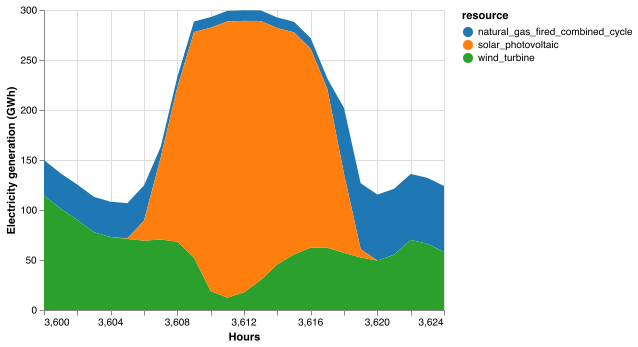

In [27]:
plot_time_interval = 3600:3624
natgas_power = Macro.value.(Macro.flow(system.assets[2].elec_edge)).data[plot_time_interval] / 1e3;
solar_power = Macro.value.(Macro.flow(system.assets[3].edge)).data[plot_time_interval] / 1e3;
wind_power = Macro.value.(Macro.flow(system.assets[4].edge)).data[plot_time_interval] / 1e3;

elec_gen = DataFrame(hours=plot_time_interval,
    solar_photovoltaic=solar_power,
    wind_turbine=wind_power,
    natural_gas_fired_combined_cycle=natgas_power,
)

stack_elec_gen = stack(elec_gen, [:natural_gas_fired_combined_cycle, :wind_turbine, :solar_photovoltaic], variable_name=:resource, value_name=:generation);

elc_plot = stack_elec_gen |>
           @vlplot(
    :area,
    x = {:hours, title = "Hours"},
    y = {:generation, title = "Electricity generation (GWh)", stack = :zero},
    color = {"resource:n", scale = {scheme = :category10}},
    width = 400,
    height = 300
)

**Task:** Set a strict net-zero $\text{CO}_2$ cap by removing the slack allowing constraint violation for a penalty. This can be done by deleting the field `price_unmet_policy` from the $\text{CO}_2$ node in file `one_zone_electricity_only/system/nodes.json`

Then, re-run the model with these new inputs and show the capacity results, total system cost, emissions, and plot the generation profiles.

<details>
<summary>Solution</summary>

Open file `one_zone_electricity_only/system/nodes.json`, go to the bottom of the file where the $\text{CO}_2$ node is defined. Remove the lines related to the field `price_unmet_policy`, so that the node definition looks like this:

```json
 {
    "type": "CO2",
    "global_data": {
        "time_interval": "CO2"
    },
    "instance_data": [
        {
            "id": "co2_sink",
            "constraints": {
                "CO2CapConstraint": true
            },
            "rhs_policy": {
                    "CO2CapConstraint": 0
                }   
        }
    ]
}
```
Then, you need to re-load the inputs:
```julia
    system = Macro.load_system("one_zone_electricity_only");
```
generate the MACRO model:
```julia
    model = Macro.generate_model(system);
```
and solve it:
```julia
    Macro.set_optimizer(model, HiGHS.Optimizer);
    Macro.optimize!(model)
```
We can check the results by printing the total system cost:
```julia
    Macro.objective_value(model)
```
and the new emissions (which should be zero):
```julia
    co2_node_idx = findfirst(isa.(system.locations,Node{CO2}).==1)
    Macro.value(sum(system.locations[co2_node_idx].operation_expr[:emissions]))
```
Finally, we plot the generation results:
```julia
    plot_time_interval = 3600:3624
    natgas_power =  Macro.value.(Macro.flow(system.assets[2].elec_edge)).data[plot_time_interval]/1e3;
    solar_power = Macro.value.(Macro.flow(system.assets[3].edge)).data[plot_time_interval]/1e3;
    wind_power = Macro.value.(Macro.flow(system.assets[4].edge)).data[plot_time_interval]/1e3;

    elec_gen =  DataFrame( hours = plot_time_interval, 
                    solar_photovoltaic = solar_power,
                    wind_turbine = wind_power,
                    natural_gas_fired_combined_cycle = natgas_power,
                    )

    stack_elec_gen = stack(elec_gen, [:natural_gas_fired_combined_cycle,:wind_turbine,:solar_photovoltaic], variable_name=:resource, value_name=:generation);

    elc_plot = stack_elec_gen |> 
    @vlplot(
        :area,
        x={:hours, title="Hours"},
        y={:generation, title="Electricity generation (GWh)",stack=:zero},
        color={"resource:n", scale={scheme=:category10}},
        width=400,
        height=300
    )
```
</details>

